In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [51]:
dd_data = pd.read_csv('data_experiencedT/DD_ProcessedComplete.csv')

# For all countries get the Year 2018 and DD_type CDD18
dd_data = dd_data.loc[(dd_data['Year'] == 2018) & (dd_data['DD_type'] == 'CDD18')]
# Drop all columns except ISO3 and DD_mean
dd_data = dd_data[['ISO3', 'DD_mean']]
#Make ISO3 as index
dd_data = dd_data.set_index('ISO3')

In [52]:
# Open gdp nc file
gdp_data = pd.read_csv('data_experiencedT/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5871588.csv')
# Drop all columns except Country Code and 2018
gdp_data = gdp_data[['Country Code', '2018']]
# Rename Country Code to ISO3
gdp_data = gdp_data.rename(columns={'Country Code': 'ISO3'})
# Make ISO3 as index
gdp_data = gdp_data.set_index('ISO3')
# Rename 2018 to GDP
gdp_data = gdp_data.rename(columns={'2018': 'GDP'})


In [53]:
# Merge the two dataframes
merged_data = pd.merge(dd_data, gdp_data, on='ISO3')

In [54]:
def sat(cdd):
    return (1.00 - 0.949*np.exp(-0.00187*cdd))

infl_factor = 0.5
def avail(gdp):
    return (1/(1+np.exp(4.152)*np.exp(-0.237*infl_factor*gdp/1000)))

def exposure(gdp, cdd):
    return (1 - avail(gdp)*sat(cdd))

In [55]:
# Add AC column to merged_data
# source: https://www.iea.org/data-and-statistics/charts/percentage-of-households-equiped-with-ac-in-selected-countries-2018
merged_data['AC'] = np.nan
merged_data.loc[merged_data.index == 'JPN', 'AC'] = 0.91
merged_data.loc[merged_data.index == 'USA', 'AC'] = 0.9
merged_data.loc[merged_data.index == 'KOR', 'AC'] = 0.86
merged_data.loc[merged_data.index == 'SAU', 'AC'] = 0.63
merged_data.loc[merged_data.index == 'CHN', 'AC'] = 0.6
merged_data.loc[merged_data.index == 'MEX', 'AC'] = 0.16
merged_data.loc[merged_data.index == 'BRA', 'AC'] = 0.16
merged_data.loc[merged_data.index == 'IDN', 'AC'] = 0.09
merged_data.loc[merged_data.index == 'ZAF', 'AC'] = 0.06
merged_data.loc[merged_data.index == 'IND', 'AC'] = 0.05
# Save AC data as csv
merged_data.to_csv('data_experiencedT/AC_data.csv', index=True)

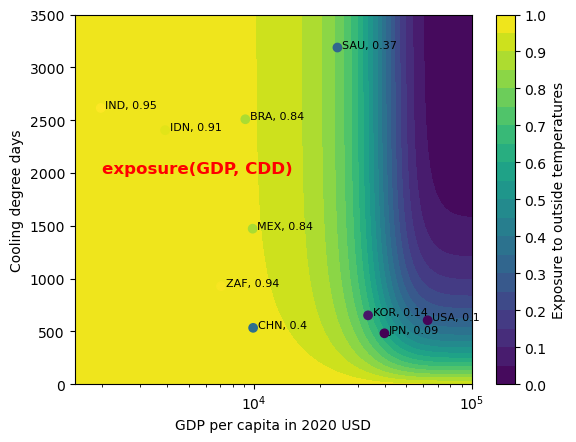

In [56]:
# Make a contour plot of penetration of air conditioning as a function of GDP per capita and cooling degree days
plt.figure()
cdd_x = np.linspace(0, 3500, 100)
gdp_x = np.linspace(0, 100000, 100)
levels = np.linspace(0, 1, 21)
cdd_x, gdp_x = np.meshgrid(cdd_x, gdp_x)
plt.contourf(gdp_x, cdd_x, exposure(gdp_x, cdd_x), levels=levels)

plt.xlabel('GDP per capita in 2020 USD')
# GDP log scale
plt.xscale('log')
plt.xlim(1500, 100000)
plt.ylabel('Cooling degree days')
plt.colorbar(label='Exposure to outside temperatures', ticks=np.linspace(0, 1, 11))
# color bar range is 0 to 1
plt.clim(0, 1.0)
# Add label in red and bold
plt.text(2000, 2000, 'exposure(GDP, CDD)', fontsize=12, color='red', fontweight='bold')

# Overlay AC data
# Read in AC data
ac_data = pd.read_csv('data_experiencedT/AC_data.csv')
# Remove rows with missing data
ac_data = ac_data.dropna()
# Reindex
ac_data = ac_data.reset_index(drop=True)
# Plot AC access as a function of GDP per capita and cooling degree days
plt.scatter(ac_data['GDP'], ac_data['DD_mean'], c=1.-ac_data['AC'], cmap='viridis', label='AC access')
# Label points with country names
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt+", "+str(round(1.-ac_data['AC'][i],3)), (ac_data['GDP'][i]*1.05, ac_data['DD_mean'][i]), fontsize=8)

plt.savefig('Figures/exposure_funct_analysis/exposure_contour.png', dpi=300)

  ISO3      DD_mean           GDP    AC  sat_calc
0  BRA  2508.361929   9121.020092  0.16  0.991287
1  CHN   533.091995   9905.406118  0.60  0.649792
2  IDN  2405.041162   3902.661675  0.09  0.989430
3  IND  2615.146210   1974.377730  0.05  0.992864
4  JPN   481.315526  39751.133098  0.91  0.614189
5  KOR   651.360792  33436.923065  0.86  0.719278
6  MEX  1471.855206   9857.007487  0.16  0.939476
7  SAU  3187.489303  24175.583124  0.63  0.997553
8  USA   604.579562  62823.309438  0.90  0.693614
9  ZAF   927.694056   7048.508112  0.06  0.832561


Text(0, 0.5, 'Availability')

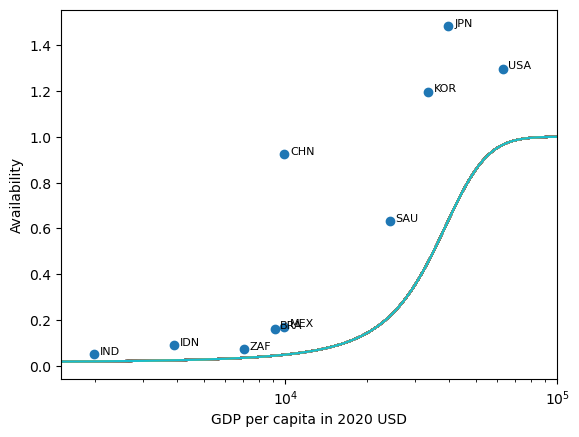

In [57]:
# Assuming saturation is true, plot availability as a function of GDP per capita
# Add column to AC data for saturation based on DD_mean
ac_data['sat_calc'] = sat(ac_data['DD_mean'])
print(ac_data)
# Compute availability as exposure/saturation
ac_data['avail_pred'] = ac_data['AC']/ac_data['sat_calc']
# Plot availability curve and data points
plt.figure()
plt.plot(gdp_x, avail(gdp_x), label='Availability prediction')
plt.scatter(ac_data['GDP'], ac_data['avail_pred'])
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred'][i]), fontsize=8)
plt.xlabel('GDP per capita in 2020 USD')
# GDP log scale
plt.xscale('log')
plt.xlim(1500, 100000)
plt.ylabel('Availability')

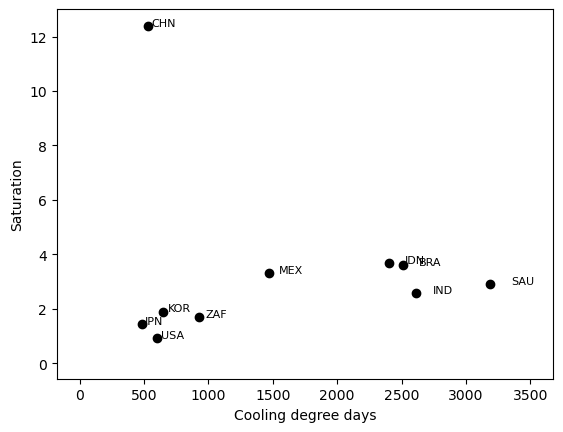

In [58]:
# Assuming availability is true, plot saturation as a function of cooling degree days
ac_data['avail_calc'] = avail(ac_data['GDP'])
# Compute saturation as exposure/availability
ac_data['sat_pred'] = ac_data['AC']/ac_data['avail_calc']
# Plot saturation curve and data points
plt.figure()
plt.plot(cdd_x, sat(cdd_x), label='Saturation prediction')
plt.scatter(ac_data['DD_mean'], ac_data['sat_pred'], color='black')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['DD_mean'][i]*1.05, ac_data['sat_pred'][i]), fontsize=8)
plt.xlabel('Cooling degree days')
plt.ylabel('Saturation')
plt.savefig('Figures/exposure_funct_analysis/avail_sat.png', dpi=300)


In [59]:
# Derive functions from scratch
import openpyxl

# Read in US state data for AC 2020
us_data =  pd.read_excel('data_experiencedT/State Air Conditioning.xlsx', header=1, skiprows=3)
# Drop rows
us_data = us_data.drop(0)
# Drop all rows with nan
us_data = us_data.dropna()
# Reindex
us_data = us_data.reset_index(drop=True)
# First column is state name
us_data = us_data.rename(columns={'Unnamed: 0': 'State'})
# Set state as index
us_data = us_data.set_index('State')
# Drop first column
us_data = us_data.drop(columns=['Unnamed: 1'])
# Rename column Unnamed: 3 to AC and drop all other columns
us_data = us_data.rename(columns={'Unnamed: 3': 'AC'})
us_data = us_data [['AC']]
us_data[['AC']] = us_data[['AC']]/100.

# Strip whitespace from index
us_data.index = us_data.index.str.strip()
# Drop rows for Hawaii and Alaska
us_data = us_data[us_data.index != 'Hawaii']
us_data = us_data[us_data.index != 'Alaska']


In [60]:
# Read in US state data for DD 2020
state_cdd_data = pd.read_csv('data_experiencedT/heating-cooling_fig-3.csv', skiprows=6)
# Drop all rows except 2020
state_cdd_data = state_cdd_data.loc[state_cdd_data['Year/Trend'] == '2020']
state_cdd_data = state_cdd_data.drop(columns=['Year/Trend'])
# Transpose dataframe
state_cdd_data = state_cdd_data.T
# Rename index to State
state_cdd_data.index.name = 'State'
# Drop first row
state_cdd_data = state_cdd_data.rename(columns={126: 'CDD_mean'})
# Rename state names to full names instead of abbreviations
state_abbr_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
                     'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
                     'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
                     'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
                     'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
                     'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
                     'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin',
                     'WY': 'Wyoming'}
state_cdd_data.index = state_cdd_data.index.map(state_abbr_dict)

In [61]:
# Merge the two dataframes
us_state_cdd_AC_data = pd.merge(us_data, state_cdd_data, on='State')
# Save as csv
us_state_cdd_AC_data.to_csv('data_experiencedT/us_state_cdd_AC_data.csv', index=True)

[0.93169464 0.92515973 0.00492885]


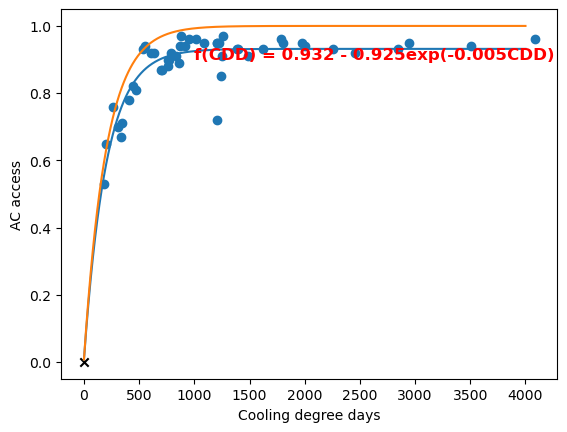

In [62]:
# Plot AC access as a function of cooling degree days
plt.figure()
plt.scatter(us_state_cdd_AC_data['CDD_mean'], us_state_cdd_AC_data['AC'])
plt.xlabel('Cooling degree days')
plt.ylabel('AC access')

# Saturation function to fit to data
def saturation_fit(cdd, a, b, c):
    return (a - b*np.exp(-c*cdd))

# Add data point at 0, 0
plt.scatter(0, 0., color='black', marker='x', label='No AC access')
us_state_cdd_AC_data.loc[len(us_state_cdd_AC_data)] = {'CDD_mean': 0, 'AC': 0.}
# Fit saturation function to data
from scipy.optimize import curve_fit
popt, pcov = curve_fit(saturation_fit, us_state_cdd_AC_data['CDD_mean'], us_state_cdd_AC_data['AC'], p0=(1, 1, 0.001))
print(popt)
# Plot saturation function fit
cdd_x_fine = np.linspace(0, 4000, 1000)
plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt), label='Saturation fit')
plt.text(1000, 0.9, 'f(CDD) = {:.3f} - {:.3f}exp(-{:.3f}CDD)'.format(popt[0], popt[1], popt[2]), fontsize=12, color='red', fontweight='bold')
# Normalize saturation function to 1
plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt)/popt[0], label='Normalized saturation fit')

plt.savefig('Figures/exposure_funct_analysis/us_state_AC.png', dpi=300)

In [63]:
ac_data

,ISO3,DD_mean,GDP,AC,sat_calc,avail_pred,avail_calc,sat_pred
0,BRA,2508.361929,9121.020092,0.16,0.991287,0.161406,0.044313,3.610702
1,CHN,533.091995,9905.406118,0.60,0.649792,0.923372,0.048420,12.391557
2,IDN,2405.041162,3902.661675,0.09,0.989430,0.090961,0.024375,3.692359
3,IND,2615.146210,1974.377730,0.05,0.992864,0.050359,0.019493,2.565078
4,JPN,481.315526,39751.133098,0.91,0.614189,1.481630,0.636108,1.430576
5,KOR,651.360792,33436.923065,0.86,0.719278,1.195643,0.452711,1.899668
6,MEX,1471.855206,9857.007487,0.16,0.939476,0.170308,0.048156,3.322501
7,SAU,3187.489303,24175.583124,0.63,0.997553,0.631545,0.216328,2.912241
8,USA,604.579562,62823.309438,0.90,0.693614,1.297551,0.964173,0.933443
9,ZAF,927.694056,7048.508112,0.06,0.832561,0.072067,0.035001,1.714239


0    0.172044
1    0.693399
2    0.096775
3    0.053764
4    1.075414
5    0.961770
6    0.172153
7    0.677419
8    1.017241
9    0.065146
Name: avail_pred_new, dtype: float64
0    1.571212
1   -0.816059
2    2.233586
3    2.867897
4         NaN
5   -3.225160
6    1.570447
7   -0.741938
8         NaN
9    2.663755
Name: avail_pred_new_transf, dtype: float64
[ 3.00922578e+00 -1.80545136e-04]


/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ISO3,DD_mean,GDP,AC,sat_calc_new,avail_pred_new,avail_pred_new_transf
0,BRA,2508.361929,9121.020092,0.16,0.929997,0.172044,1.571212
1,CHN,533.091995,9905.406118,0.60,0.865302,0.693399,-0.816059
2,IDN,2405.041162,3902.661675,0.09,0.929994,0.096775,2.233586
3,IND,2615.146210,1974.377730,0.05,0.929998,0.053764,2.867897
4,KOR,651.360792,33436.923065,0.86,0.894185,0.961770,-3.225160
5,MEX,1471.855206,9857.007487,0.16,0.929408,0.172153,1.570447
6,SAU,3187.489303,24175.583124,0.63,0.930000,0.677419,-0.741938
7,ZAF,927.694056,7048.508112,0.06,0.921005,0.065146,2.663755


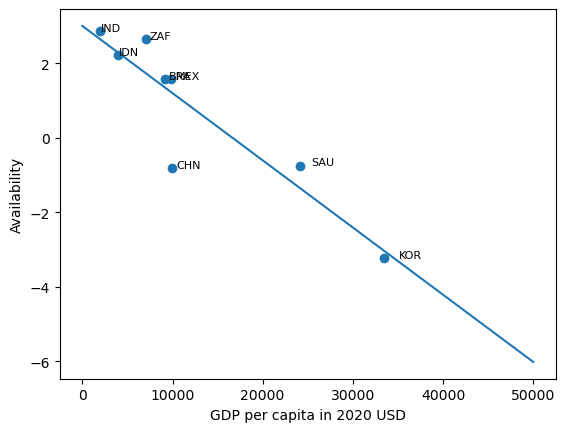

In [75]:
def saturation_new(cdd):
    return (0.93 - 0.93*np.exp(-0.005*cdd))

ac_data['sat_calc_new'] = saturation_new(ac_data['DD_mean'])
# Compute availability as exposure/saturation
ac_data['avail_pred_new'] = ac_data['AC']/ac_data['sat_calc_new']
print(ac_data['avail_pred_new'])
# Plot availability curve and data points
plt.figure()
plt.scatter(ac_data['GDP'], np.log((1./ac_data['avail_pred_new'])-1.))

ac_data['avail_pred_new_transf'] = np.log((1./ac_data['avail_pred_new'])-1.)
print(ac_data['avail_pred_new_transf'])
ac_data = ac_data.dropna()
# Reindex
ac_data = ac_data.reset_index(drop=True)

# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred_new_transf'][i]), fontsize=8)

def avail_fit(gdp, a, b):
    # return (1/(1 + a * np.exp(b*gdp)))
    return (a + b * gdp)

popt, pcov = curve_fit(avail_fit, ac_data['GDP'], ac_data['avail_pred_new_transf'])
print(popt)

# Plot availability curve and data points
gdp_x_fine = np.linspace(0, 50000, 1000)
plt.plot(gdp_x_fine, avail_fit(gdp_x_fine, *popt), label='Availability fit')

plt.xlabel('GDP per capita in 2020 USD')
plt.ylabel('Availability')

ac_data

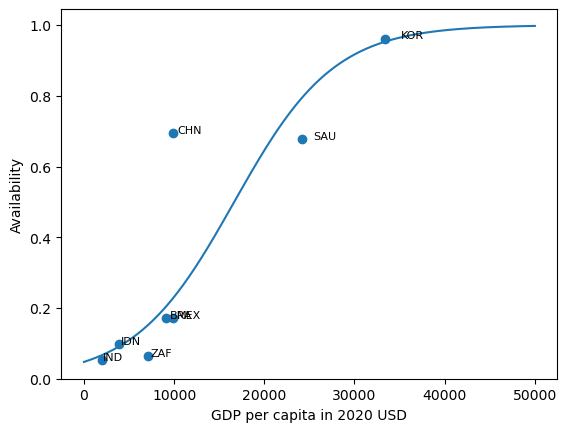

In [77]:
def avail_new(gdp):
    return (1/(1 + np.exp(3)* np.exp(-0.00018*gdp)))

# Plot availability curve and data points

plt.figure()
plt.scatter(ac_data['GDP'], ac_data['avail_pred_new'])

plt.plot(gdp_x_fine, avail_new(gdp_x_fine), label='Availability prediction')
plt.xlabel('GDP per capita in 2020 USD')
plt.ylabel('Availability')

# Label points with country names
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred_new'][i]), fontsize=8)


In [73]:
def exposure_new(gdp, cdd):
    return (1 - avail_new(gdp)*saturation_new(cdd))

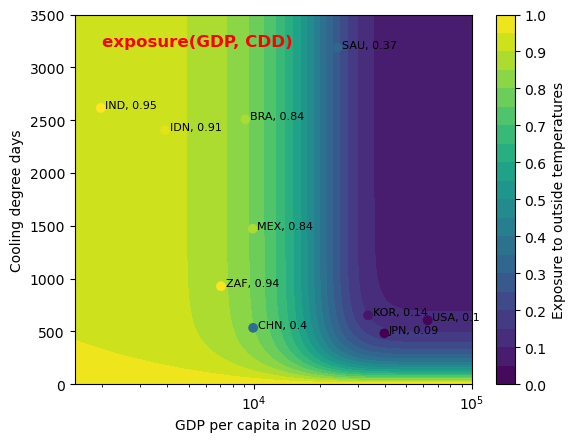

In [78]:
# Make a contour plot of penetration of air conditioning as a function of GDP per capita and cooling degree days
plt.figure()
cdd_x = np.linspace(0, 3500, 100)
gdp_x = np.linspace(0, 100000, 100)
levels = np.linspace(0, 1, 21)
cdd_x, gdp_x = np.meshgrid(cdd_x, gdp_x)
plt.contourf(gdp_x, cdd_x, exposure_new(gdp_x, cdd_x), levels=levels)

plt.xlabel('GDP per capita in 2020 USD')
# GDP log scale
plt.xscale('log')
plt.xlim(1500, 100000)
plt.ylabel('Cooling degree days')
plt.colorbar(label='Exposure to outside temperatures', ticks=np.linspace(0, 1, 11))
# color bar range is 0 to 1
plt.clim(0, 1.0)
# Add label in red and bold
plt.text(2000, 3200, 'exposure(GDP, CDD)', fontsize=12, color='red', fontweight='bold')

# Overlay AC data
# Read in AC data
ac_data = pd.read_csv('data_experiencedT/AC_data.csv')
# Remove rows with missing data
ac_data = ac_data.dropna()
# Reindex
ac_data = ac_data.reset_index(drop=True)
# Plot AC access as a function of GDP per capita and cooling degree days
plt.scatter(ac_data['GDP'], ac_data['DD_mean'], c=1.-ac_data['AC'], cmap='viridis', label='AC access')
# Label points with country names
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt+", "+str(round(1.-ac_data['AC'][i],3)), (ac_data['GDP'][i]*1.05, ac_data['DD_mean'][i]), fontsize=8)

plt.savefig('Figures/exposure_funct_analysis/exposure_new_contour.png', dpi=300)